In [1]:
library(MLmetrics)
library(tidyverse)
library(kableExtra)
library(ggplot2)
library(caret)
library(class)
library(rpart)
library(rpart.plot)
library(caTools)

options(readr.num_columns = 0)
churn <- read_csv("../_build/data/churn_train.csv")
scaler <- preProcess(churn, method="range")
churnScaled <- predict(scaler, churn)
churnScaled$international_plan <- ifelse(churnScaled$international_plan=="yes", 1, 0)
churnScaled$voice_mail_plan <- ifelse(churnScaled$voice_mail_plan=="yes", 1, 0)

Warning message:
"package 'MLmetrics' was built under R version 3.6.3"


Attaching package: 'MLmetrics'



The following object is masked from 'package:base':

    Recall



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.4  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


Warning message:
"package 'purrr' was built under R version 3.6.3"

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Warning message:
"package 'kableExtra' was built under R version 3.6.3"


Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



Loading required package: lattice



Attaching package: 'caret'



The following object is masked from 'package:purrr':

    lift



The following objects are masked from 'package:MLmetrics':

    MAE, RMSE



Warning message:
"package 'caTools' was built under R version 3.6.3"

# Partitioning Data

Let's return to the decision tree model we applied to the `churn` data in the previous chapter. In order to traverse the bias-variance tradeoff, we need to **tune** the model hyperparameter $depth$. If $depth$ is too large we risk overfitting the data and picking up on the noise of the sample, while if $depth$ is too small we risk underfitting the data and missing the signal. Consequently, we need to find the value of $depth$ that maximizes the ability of the model to make accurate predictions on unseen data.

In this section, we will use the work set to build and compare decision tree models with different values of the $depth$ parameter. Once we decide on the best value for the hyperparameter, we will then use the holdout set to evaluate the accuracy of our final model on unseen data. 

First we need to randomly split our data set (`churn`) into work (80%) and holdout (20%) sets. We can do this using the `sample.split()` function from the `caTools` package.

Note that we are *randomly* dividing the data, meaning that each observation should have a chance of being included in the work set and a chance of being included in the holdout set. We want this sampling process to be random, but we also want to ensure that every time the code is run, the same observations are sorted into the work set and the same observations are sorted into the holdout set. This will guarantee that every time the code is re-run, we have the exact same work and holdout sets. If we did not do this, two different runs of the code would almost certainly have a different set of observations in the two data sets, so the results would be different each time. 

We can ensure that a random process is stable (*i.e.*, leads to the same result) by setting the random seed with `set.seed()`. The number you pass into this function "seeds" the randomization that R uses to split the data, so two people using the same random seed will have identical splits of the data. In the code below we use a random seed of `972941`, a number which was itself randomly chosen.

After setting the random seed we then apply `sample.split()`, which uses the following syntax:

```{admonition} Syntax
`caTools::sample.split(Y, SplitRatio = 2/3)`
+ *Required arguments*
  - `Y`: An atomic vector with the values of the target feature in the data set. 
+ *Optional arguments*
  - `SplitRatio`: The proportion of observations to use for the training set. The remaining observations are used for the validation set.
```

Below we save the output of `sample.split()` into `split1`, a vector with either `TRUE` or `FALSE` for each observation in our data set. An element of `split1` is set equal to `TRUE` if the observation is assigned to the work set and `FALSE` if the observation is assigned to the holdout set. We can therefore use `split1` to create the two separate data sets `work` and `holdout` using the `subset()` function.

In [2]:
# Set the random seed
set.seed(972943)

# Define the work and holdout sets
split1 <- sample.split(churn$churn, SplitRatio = 0.8)

# Split the data into two data frames
work <- subset(churnScaled, split1 == TRUE)
holdout <- subset(churnScaled, split1 == FALSE)

To confirm the 80/20 split, let's output the dimensions of the new `work` and `holdout` sets.

In [3]:
dim(work)
dim(holdout)

[1] 2720   13

[1] 680  13

## The Work Set

Recall that the work set is used to build and compare models with different values of any applicable hyperparameters. One way to do this is to further divide the work set into a single training set, which is used to build different models, and a single validation set, which is used to compare the performance of those models. This procedure is covered in the first subsection below. The second subsection covers an alternative method known as $k$-fold cross validation that divides the work set into $k$ different training and validation sets. 

### Train/Validation Sets

Now that we've set aside 80% of our data into `work`, we need to further divide the work set into training and validation sets. To do this we will use the same `sample.split()` function we saw in the introduction. Note that we want 60% of the full data set to be used for the training set and 20% of the full data set to be used for the validation set. Therefore, we will divide the work set (which contains 80% of the full data set) with a 75% / 25% split. Because 0.75 * 0.8 = 0.6, this will ensure that the training set has 60% of all observations.

In [4]:
# Set the random seed
set.seed(972943)

# Define the train and validate sets
split2 <- sample.split(work$churn, SplitRatio = 0.75)

# Split the data into two data frames
train <- subset(work, split2 == TRUE)
validate <- subset(work, split2 == FALSE)

If we view the dimensions of `train`, `validate`, and `holdout`, we can see that `train` contains 60% of the observations, `validate` contains 20%, and `holdout` contains 20%.

In [5]:
dim(train)
dim(validate)
dim(holdout)

[1] 2040   13

[1] 680  13

[1] 680  13

The **training set** we just defined will be used to build different decision tree models with different values of the hyperparameter $depth$. We start by defining a **grid** of different values for the hyperparameter that we want to test. In this case, our grid will be $depth = \{1, 2, 4\}$. We then use the training set to build three different models, each with a different value of $depth$. In the code below, we fit all three of these models on `train` using the `rpart()` function.

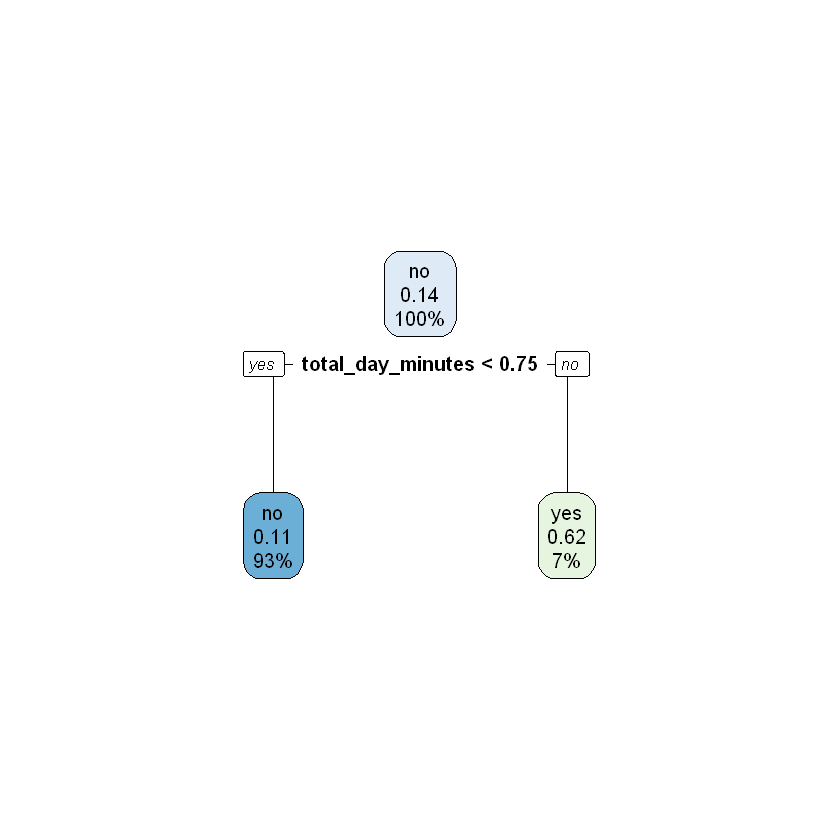

In [6]:
modelDepth1 <- rpart(churn ~ ., data = train, maxdepth = 1)
rpart.plot(modelDepth1)

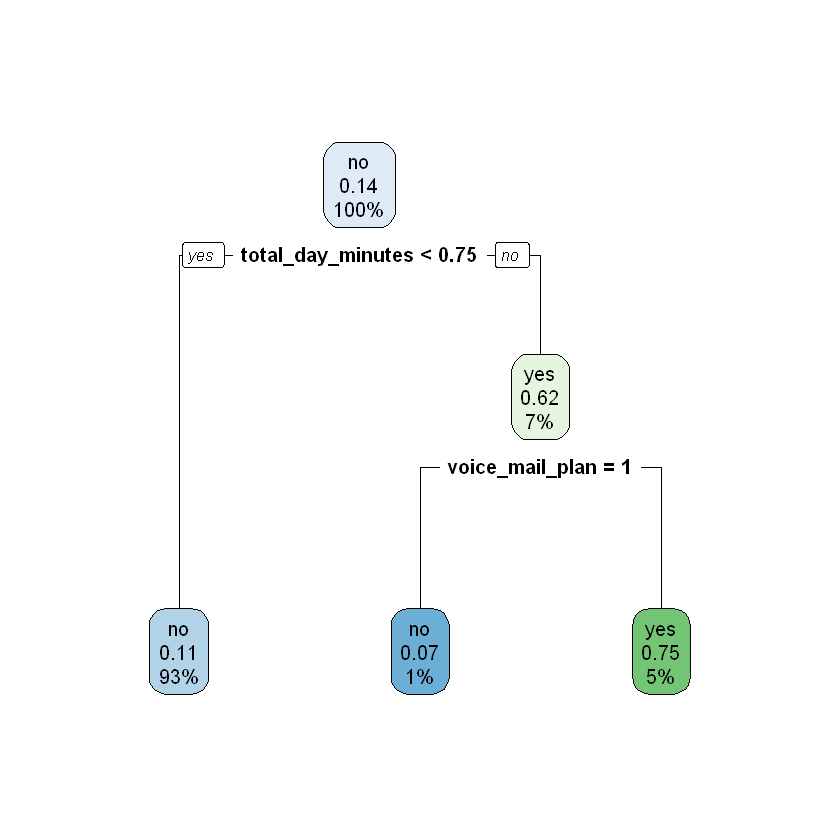

In [7]:
modelDepth2 <- rpart(churn ~ ., data = train, maxdepth = 2)
rpart.plot(modelDepth2)

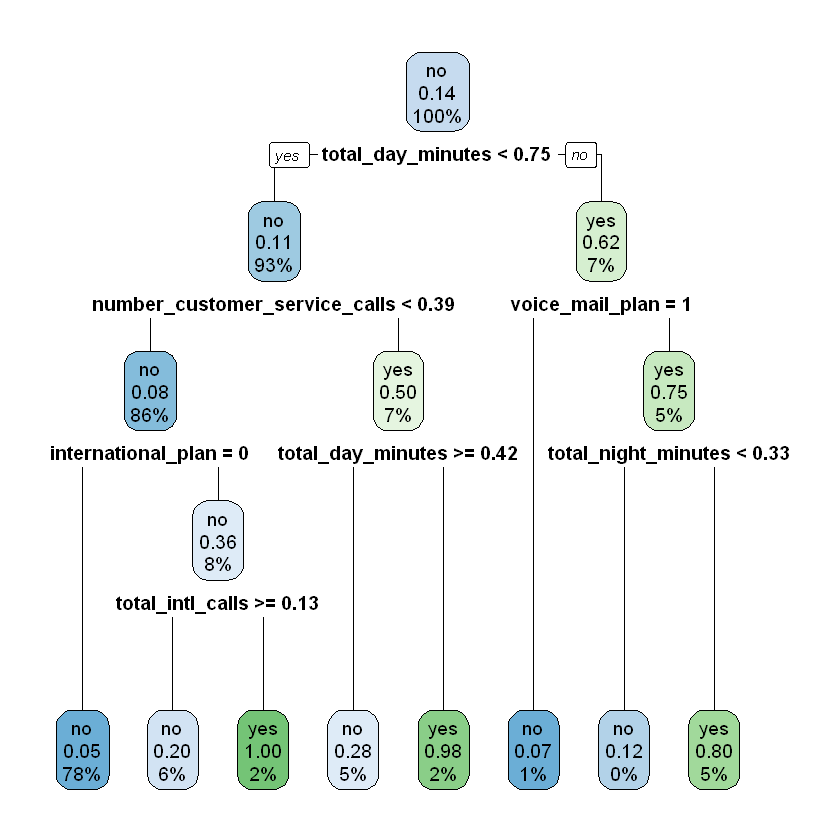

In [8]:
modelDepth4 <- rpart(churn ~ ., data = train, maxdepth = 4)
rpart.plot(modelDepth4)

Next, we apply all three of these models to the **validation set**, which is used to compare the accuracy of the different models. Whichever value of $depth$ results in the most accurate predictions on the validation set is taken to be the optimal value. We can apply our three models to the validation set using the same `predict()` function we have seen before in the context of linear and logistic regression. With `rpart` models, we can include `type = "class"` in our call to `predict()`, which will return a discrete prediction of `"yes"` or `"no"` for each observation (instead of a continuous probability). In the cell below, we create a new column in `validate` wth each model's predictions.

In [9]:
validate$modelDepth1Pred <- predict(modelDepth1, validate, type = "class")
validate$modelDepth2Pred <- predict(modelDepth2, validate, type = "class")
validate$modelDepth4Pred <- predict(modelDepth4, validate, type = "class")

head(validate)

account_length international_plan voice_mail_plan number_vmail_messages
1 0.1446281      0                  0               0.00                 
2 0.5909091      0                  1               0.66                 
3 0.3842975      0                  0               0.00                 
4 0.4669421      0                  1               0.62                 
5 0.2851240      0                  0               0.00                 
6 0.2561983      0                  1               0.26                 
  total_day_minutes total_day_calls total_night_minutes total_night_calls
1 0.5061166         0.7818182       0.7754430           0.6000000        
2 0.7157895         0.5272727       0.5296203           0.5705882        
3 0.4950213         0.5151515       0.5260759           0.5529412        
4 0.6338549         0.5939394       0.3830380           0.5941176        
5 0.4221906         0.6666667       0.3835443           0.5941176        
6 0.6093883         0.3696970       0.4405063           0.4000000        
  total_intl_minutes total_intl_calls total_intl_charge
1 0.540              0.30             0.5407407        
2 0.610              0.15             0.6092593        
3 0.395              0.05             0.3944444        
4 0.650              0.20             0.6500000        
5 0.445              0.20             0.4444444        
6 0.515              0.10             0.5148148        
  number_customer_service_calls churn modelDepth1Pred modelDepth2Pred
1 0.2222222                     no    no              no             
2 0.2222222                     no    no              no             
3 0.1111111                     no    no              no             
4 0.0000000                     no    no              no             
5 0.0000000                     no    no              no             
6 0.0000000                     no    no              no             
  modelDepth4Pred
1 no             
2 no             
3 no             
4 no             
5 no             
6 no

To determine the performance of each model on the validation set, we need to compare the model's predictions against the known, true values. Here we will score the models using **accuracy**, or the proportion of observations where the model's prediction matched the true value. In the section [Performance Metrics](performance_metrics.html#performance-metrics), we will learn about other metrics that can be used to assess model performance. 

We can easily calculate the accuracy of our models on the validation set using the `Accuracy()` function from the `MLmetrics` package, which uses the following syntax:

```{admonition} Syntax
`MLmetrics::Accuracy(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model predictions. 
  - `y_true`: An atomic vector with the true labels. 
```

To use `Accuracy()`, we pass in our vector of model predictions as `y_pred` and the true values (stored in the column `validate$churn`) as `y_true`:

In [10]:
Accuracy(validate$modelDepth1Pred, validate$churn)

[1] 0.875

This means that our model of depth one correctly predicted 87.5% of the observations in the `validate` set. Now let's apply this to the other models:

In [11]:
Accuracy(validate$modelDepth2Pred, validate$churn)
Accuracy(validate$modelDepth4Pred, validate$churn)

[1] 0.8838235

[1] 0.9132353

Based on these results, we can conclude that the best value for $depth$ is four. 

Now that we have chosen a value for $depth$, we would fit a final model with $depth$ equal to four using the entire work set (*i.e.*, the combined training and validation sets). This is the model we would actually deploy to predict which customers will churn in the upcoming quarter.

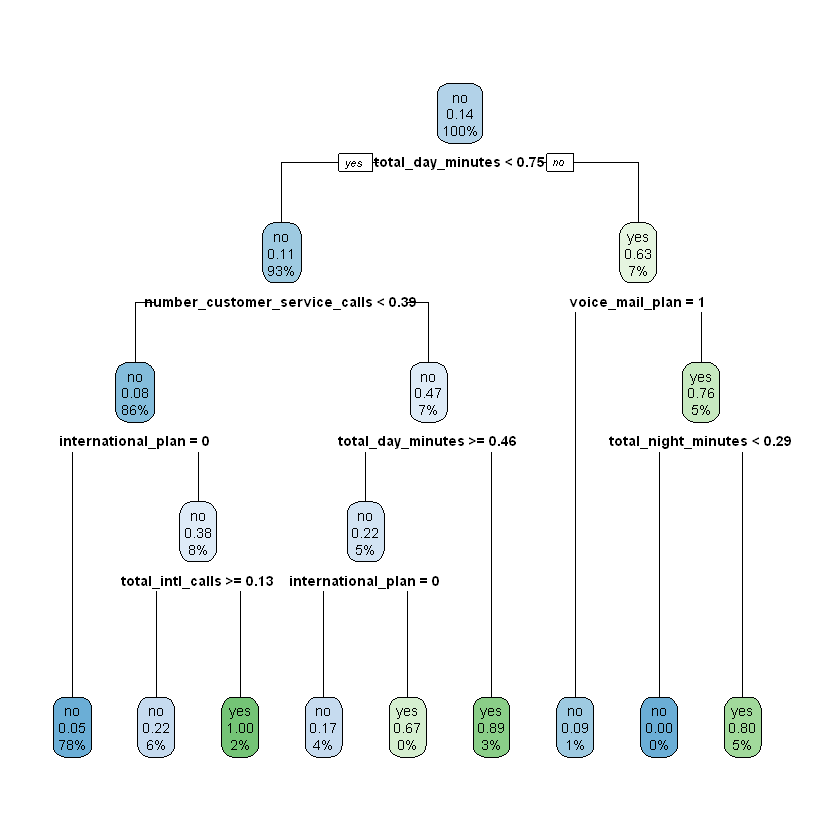

In [12]:
modelDT <- rpart(churn ~ ., data = work, maxdepth = 4)
rpart.plot(modelDT)

### $k$-Fold Cross Validation

There is no reason we must divide the work set into only a single train and and a single validation set, as we did in the previous section. An alternative method for training and validating models is called **$k$-fold cross validation**. $k$-fold cross validation randomly divides our work set into $k$ partitions (called folds). It then builds a model on all but one of these folds, and uses the held-out fold to validate that model's predictive ability. It then repeats this procedure $k$ times, each time holding out a different one of the $k$ folds.  

For example, we would apply the following steps if we chose a $k$ of four:

1. Randomly divide the work set into four equally-sized folds.
2. Treat the fourth fold as the validation set and train the model on the first three folds.
3. Evaluate the model's performance on the fourth fold.
4. Repeat Steps 2 and 3 three more times, but each time treat a different fold as the validation set. 
5. Calculate the overall model performance by averaging the four performance estimates from Step 3.

Although this may sound complicated at first, it is not all that different from the train/validation split described in the previous section. Consider the figure below. As you can see, $k$-fold cross validation can be thought of as a generalization of the train/validation split, where for each of the $k$ iterations a different portion of the data is used as the validation set. 

```{figure} ../_build/html/_images/kfoldV2.png
---
height: 550px
---
```

<br>

With a single train/validation split, we have a single accuracy estimate for each of the three decision tree models we fit. For example, in the previous section the decision tree with a $depth$ of four returned an accuracy of 91.32% on the validation set. However, with $k$-fold cross validation we get $k$ accuracy estimates for each model. From the figure above, we would have four separate estimates of a model's accuracy because we effectively have four different validation sets. For a final estimate of a model's performance, we average these $k$ estimates together. 

To build and evaluate a decision tree model with $k$-fold cross validation, we simply add the optional `control` parameter in our call to `rpart()`. In the cell below, we cross validate a decision tree with a $depth$ of one by including `control = rpart.control(xval = 4, maxdepth = 1)`. The `rpart.control()` function (documentation [here](https://www.rdocumentation.org/packages/rpart/versions/4.1.16/topics/rpart.control)) is used to specify the conditions of the cross validation that we would like to perform. The `xval` parameter within `rpart.control()` indicates the desired number of folds (*i.e.* $k$). The `maxdepth` parameter indicates the desired value for $depth$. Finally, by applying the `printcp()` function to our model object (`modeDepth1CV`) we can view the results of the cross validation.

In [13]:
modelDepth1CV <- rpart(churn ~ ., data = work, control = rpart.control(xval = 4, maxdepth = 1))
printcp(modelDepth1CV)


Classification tree:
rpart(formula = churn ~ ., data = work, control = rpart.control(xval = 4, 
    maxdepth = 1))

Variables actually used in tree construction:
[1] total_day_minutes

Root node error: 390/2720 = 0.14338

n= 2720 

       CP nsplit rel error  xerror     xstd
1 0.11538      0   1.00000 1.00000 0.046866
2 0.01000      1   0.88462 0.93846 0.045635


The table at the bottom of this output provides the main results. Note that there are two rows, which indicates that the cross validation procedure was actually performed twice. This is because the decision tree model has additional hyperparemeters we have not been considering, `cp` and `nsplit` (see [here](https://www.rdocumentation.org/packages/rpart/versions/4.1.16/topics/rpart.control) for more information). Although we fixed the `maxdepth` parameter at `1`, we did not fix the value of these additional parameters, so behind the scenes the `rpart` function tested a few different values for each one. This means that four-fold cross validation was applied once with a decision tree model where (`maxdepth` = `1`, `cp` = `0.11538`, `nsplit` = `0`) and once with a decision tree where (`maxdepth` = `1`, `cp` = `0.01000`, `nsplit` = `1`). 

Of these two models, which one resulted in the best performance? Unfortunately the output does not directly provide the accuracy estimates from the cross validation procedure. Instead we need to do a bit of simple math to convert the results in the `rel error` column to our standard accuracy measure. 

The line in the output `Root node error: 390/2720 = 0.14338` indicates that the base error rate for the data set is 14.338%. This means that of the 2,720 observations in the work set, 390 (or 14.338%) of them churned. Imagine that instead of building a model, we just naively predicted that every observation would not churn. In this case, we would still be correct for 2,330 of the observations and achieve a (seemingly high) accuracy of 85.662%, even though we would miss all of the 390 observations that did churn. Therefore, we want to compare any model we build against the baseline accuracy of 85.662%. If our model is not more accurate than 86%, it may not be better than blindly guessing "will not churn" for every observation. The root node error of 0.14338 is the complement of the baseline accuracy (1 - 0.14338 = 0.85662).

In the output, the `rel error` column indicates the error of each model *relative* to the baseline (or root node) error of 0.14338. Based on the cross validation procedure, the first decision tree model (where `maxdepth` = `1`, `cp` = `0.11538`, `nsplit` = `0`) achieved a relative error of 1. This means that its overall error was 1 * 0.14338 = 0.14338. To convert this to a final accuracy estimate for the model, we simply subtract this number from 1, so 1 - 0.14338 = 0.85662. This means that the first model is likely no better than blindly guessing "will not churn" for every observation. The second decision tree model (where `maxdepth` = `1`, `cp` = `0.01000`, `nsplit` = `1`) achieved a relative error of 0.88462 for an overall error of 0.88462 * 0.14338 = 0.12684. This means that this model's accuracy estimate is 87.316% (1 - 0.12684 = 0.87316). Note that because we are applying four-fold cross validation, the error estimates in the `rel error` column are an average of four different estimates. 

We can view the best model by applying the `rpart.plot()` function to our `modelDepth1CV` object.

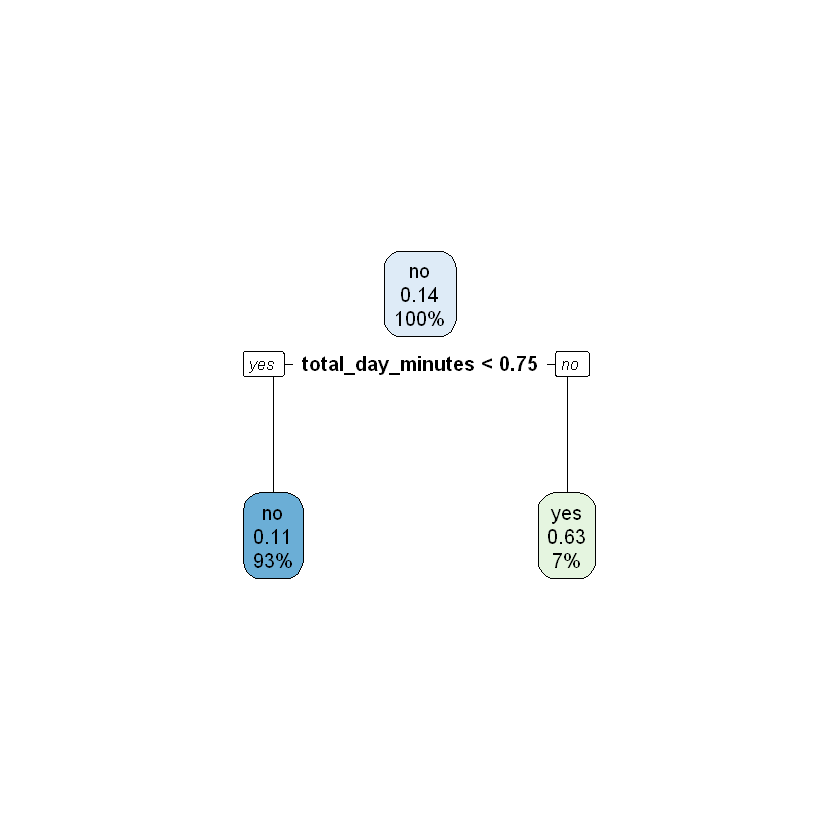

In [14]:
rpart.plot(modelDepth1CV)

Next we will apply four-fold cross validation with a `maxdepth` of 2 and a `maxdepth` of 4.


Classification tree:
rpart(formula = churn ~ ., data = work, control = rpart.control(xval = 4, 
    maxdepth = 2))

Variables actually used in tree construction:
[1] total_day_minutes voice_mail_plan  

Root node error: 390/2720 = 0.14338

n= 2720 

        CP nsplit rel error  xerror     xstd
1 0.115385      0   1.00000 1.00000 0.046866
2 0.074359      1   0.88462 0.97692 0.046412
3 0.010000      2   0.81026 0.83590 0.043433


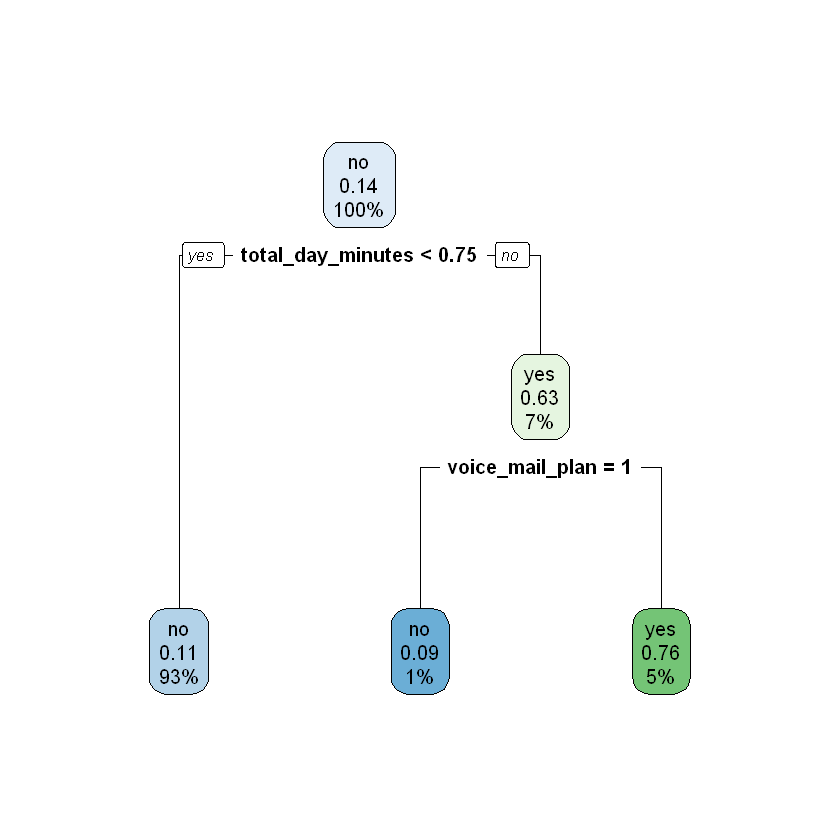

In [15]:
modelDepth2CV <- rpart(churn ~ ., data = work, control = rpart.control(xval = 4, maxdepth = 2))
printcp(modelDepth2CV)
rpart.plot(modelDepth2CV)


Classification tree:
rpart(formula = churn ~ ., data = work, control = rpart.control(xval = 4, 
    maxdepth = 4))

Variables actually used in tree construction:
[1] international_plan            number_customer_service_calls
[3] total_day_minutes             total_intl_calls             
[5] total_night_minutes           voice_mail_plan              

Root node error: 390/2720 = 0.14338

n= 2720 

        CP nsplit rel error  xerror     xstd
1 0.115385      0   1.00000 1.00000 0.046866
2 0.076923      1   0.88462 0.92564 0.045370
3 0.074359      3   0.73077 0.75897 0.041645
4 0.056410      4   0.65641 0.75897 0.041645
5 0.020513      6   0.54359 0.57436 0.036762
6 0.010256      7   0.52308 0.56923 0.036612
7 0.010000      8   0.51282 0.54872 0.036004


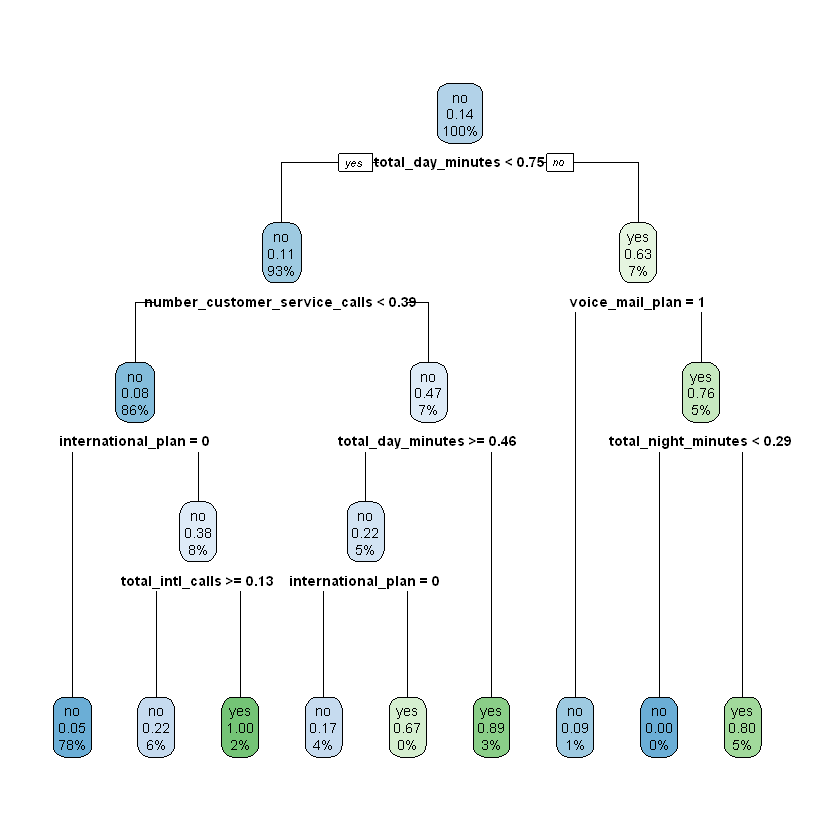

In [16]:
modelDepth4CV <- rpart(churn ~ ., data = work, control = rpart.control(xval = 4, maxdepth = 4))
printcp(modelDepth4CV)
rpart.plot(modelDepth4CV)

Based on these results, the lowest error was achieved for the decision tree model where `maxdepth` = `4`, `cp` = `0.010000`, and `nsplit` = `8`. For this model the `rel error` was 0.51282, which translates to an accuracy estimate of (1 - (0.51282 * 0.14338) = 0.92647), or 92.647%. 

## Holdout Sets

Now we have decided on a final model specification (`maxdepth` = `4`, `cp` = `0.010000`, `nsplit` = `8`). We know how this model performs on the validation set (or through $k$-fold cross validation), but this still does not provide an unbiased estimate for how our model will perform on unseen data. The reason for this is that although the model may not be directly trained on the observations in the validation set, the validation set was still used to tune the model's hyperparameters. This means that the validation set had some influence on how the model was built. Consequently, it cannot provide a completely unbiased estimate for how the model will perform on observations it has never encountered before. For this, we need to evaluate our final model on the holdout set that we set aside at the beginning of this section. 

It is important to emphasize that the holdout set should *never* influence the model building process. If you use the holdout set to make decisions about your model (which algorithm to use, the values of any hyperparameter(s), etc.), the holdout set can no longer provide a completely unbiased estimate of your model's performance. Therefore, you should only look at the holdout set after you have decided on a final model.

We can calculate the accuracy of our final model (`modelDepth4CV`) on the holdout set (`holdout`) using the same `predict()` and `Accuracy()` functions we saw in the section [Train/Validation Sets](data_partition.html#train-validation-sets).

In [17]:
holdout$modelPred <- predict(modelDepth4CV, holdout, type = "class")
Accuracy(holdout$modelPred, holdout$churn)

[1] 0.9102941

This indicates that if we were to deploy the model to actually predict which customers will churn, it will likely achieve an accuracy of 91%. This is the estimate that we should provide to stakeholders when presenting the model. 

## Summary

To summarize the model building process:

1. Randomly divide the available data into a work set (80%) and a holdout set (20%). 
2. Compare and tune different models on the work set, using either a single train/validation split or $k$-fold cross validation. 
3. Once you have decided on a final model, train that model on the entire work set. 
4. Calculate the accuracy of your final model on the holdout set to estimate its performance on completely unseen data.